# Programming assignment 4
(adapted from the work done by Erik Learned-Miller, which was originally developed by Fei-Fei Li, Andrej Karpathy, and Justin Johnson)

## Overview
<font size='4'> In this assignment you will practice putting together a simple image classification pipeline, based on the SVM/Softmax classifier and simple fully-connected networks. The goals of this assignment are as follows:

- <font size='4'>understand the basic Image Classification pipeline and the data-driven approach (train/predict stages)
- <font size='4'>understand the train/val/test splits and the use of validation data for hyperparameter tuning.
- <font size='4'>implement and apply a Multiclass Support Vector Machine (SVM) classifier
- <font size='4'>implement and apply a two-layer neural network classifier
- <font size='4'>implement and apply an arbitrary-layer neural network classifier
- <font size='4'>understand the differences and tradeoffs between these classifiers

## Submission format
* <font size='4'>`<your_nu_username>_linear_classifier.ipynb` (finished this file)
* <font size='4'>`<your_nu_username>_fc_net.ipynb` (finished the other file)
    
## Note: 
* <font size='4'>Do not install any additional packages inside the conda environment. The TAs will use the same environment as defined in the config files we provide you, so anything that’s not in there by default will probably cause your code to break during grading. Failure to follow any of these instructions will lead to point deductions. 
* <font size='4'>We have some inline questions embedded in the Jupyter notebook files. Do not miss them.


## Setup

In [1]:
from __future__ import print_function
import random
import numpy as np
import time
from utils.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# let's download the data
%cd ../datasets

# 1 -- Linux 
# 2 -- MacOS
# 3 -- Command Prompt on Windows
# 4 -- manually downloading the data
choice = 3


if choice == 1:
    # should work well on Linux and in Powershell on Windows
    !wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
elif choice == 2 or choice ==3:
    # if wget is not available for you, try curl
    # should work well on MacOS
    !curl http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz --output cifar-10-python.tar.gz
else:
    print('Please manually download the data from http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz and put it under the datasets folder.')
!tar -xzvf cifar-10-python.tar.gz

if choice==3:
    !del cifar-10-python.tar.gz
else:
    !rm cifar-10-python.tar.gz

D:\CS 5330\pa4\pa4\datasets


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  162M    0 1565k    0     0  1565k      0  0:01:46 --:--:--  0:01:46 2223k
  6  162M    6 10.1M    0     0  10.1M      0  0:00:15  0:00:01  0:00:14 6120k
 21  162M   21 35.3M    0     0  17.6M      0  0:00:09  0:00:02  0:00:07 13.0M
 45  162M   45 73.6M    0     0  24.5M      0  0:00:06  0:00:03  0:00:03 19.8M
 62  162M   62  101M    0     0  25.3M      0  0:00:06  0:00:04  0:00:02 21.5M
 80  162M   80  131M    0     0  26.2M      0  0:00:06  0:00:05  0:00:01 25.9M
 96  162M   96  157M    0     0  26.2M      0  0:00:06  0:00:06 --:--:-- 29.4M
100  162M  100  162M    0     0  27.0M      0  0:00:06  0:00:06 --:--:-- 30.3M
x cifar-10-batches-py/
x cifar-10-batches-py/data_batch_4
x cifar-10-batches-py/readme.html
x cifar-10-batches-py/test_batch
x cif

In [3]:
# Load the raw CIFAR-10 data.
cifar10_dir = '../datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


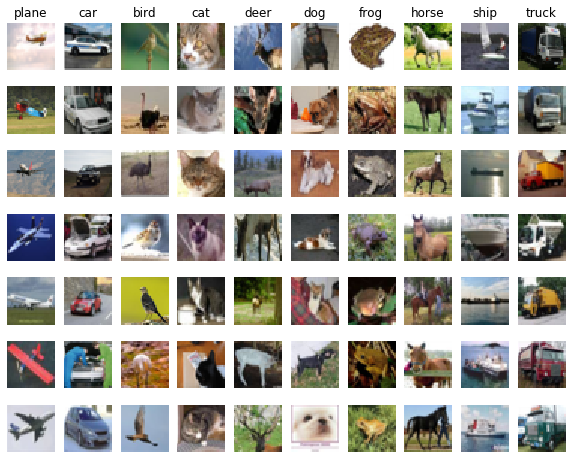

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [6]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


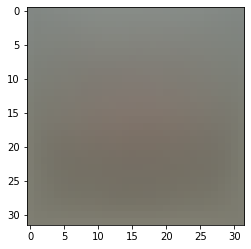

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [7]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

# Programming assignments start here (100 points in total including the other Jupyter notebook file).

## Part 1: Cross-entropy Loss (8 points)

<font size="4" color="red">**Task 1.1: implement the cross-entropy loss for classification (6 points)**</font>
<br><font size="4">(Note no foor loops are allowed.)

In [8]:
def softmax_loss_vectorized(W, X, y, reg):
    """
    Softmax loss function, vectorized version.

    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.
    - reg: (float) regularization strength

    Returns a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    
    Hint: You can start with a naive implementation with for loops and vecterize it.
    But no for loops are allowed to use in your final implementation.
    """
    
    # Initialize the loss and gradient to zero.
    loss = 0.0
    dW = np.zeros_like(W)

    #############################################################################
    # TODO: Compute the softmax loss and its gradient using no explicit loops.  #
    # Store the loss in loss and the gradient in dW. If you are not careful     #
    # here, it is easy to run into numeric instability. Don't forget the        #
    # regularization!                                                           #
    #############################################################################
    num_classes = W.shape[1]
    num_train = X.shape[0] 

    score = X.dot(W)
    score -= np.max(score, axis = 1, keepdims = True)
    p = np.exp(score) / np.sum(np.exp(score),axis=1,keepdims=True)

    loss = np.sum(-np.log(p[range(num_train), y]))
    loss /= num_train
    loss += 0.5 * reg * np.sum(W * W)

    p[range(num_train), y] -= 1
    dW = X.transpose().dot(p)
    dW /= num_train
    dW += reg * W 

    #pass
    #############################################################################
    #                          END OF YOUR CODE                                 #
    #############################################################################

    return loss, dW

In [9]:
# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_vectorized(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))
assert np.abs(loss + np.log(0.1)) < 0.1

loss: 2.329192
sanity check: 2.302585


<font size='4' color="red"> **Inline Question 1.2:**
<font size='4'>**Why do we expect our loss to be close to -log(0.1)? Explain briefly. (2 points)**</font>

**Fill in your answer below**
    
[FILL IN THIS] We expect loss to be close to -log(0.1) because when we initialize the weight (W) matrix with random small values, expected return scores will be close to zero. Hence, at the start of algorithm, in the first iteration we always expect a loss close to $-log(\frac{1}{C})$, where C is the number of classes in the dataset. In CIFAR-10 dataset we have 10 classes, i.e. probability of obtaining correct class will be 0.1 and the softmax loss is the negative log probability of the correct class, therefore it is -log(0.1).


In [10]:
# Let's check your implementation
loss, grad = softmax_loss_vectorized(W, X_dev, y_dev, 0.0)

# We use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from utils.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_vectorized(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_vectorized(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_vectorized(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -1.223098 analytic: -1.223098, relative error: 4.421598e-09
numerical: -0.882006 analytic: -0.882006, relative error: 1.673588e-08
numerical: 0.630200 analytic: 0.630200, relative error: 1.334668e-08
numerical: 0.205445 analytic: 0.205445, relative error: 2.079051e-07
numerical: -4.474977 analytic: -4.474977, relative error: 1.103264e-08
numerical: -0.321279 analytic: -0.321279, relative error: 3.962484e-08
numerical: -2.857794 analytic: -2.857794, relative error: 1.591148e-08
numerical: -1.138887 analytic: -1.138887, relative error: 1.097961e-08
numerical: -0.005661 analytic: -0.005661, relative error: 7.570051e-06
numerical: 0.391441 analytic: 0.391441, relative error: 9.145752e-08
numerical: -1.180274 analytic: -1.180274, relative error: 1.257625e-08
numerical: 1.985949 analytic: 1.985949, relative error: 5.744738e-09
numerical: 0.420983 analytic: 0.420983, relative error: 1.323781e-08
numerical: 0.679483 analytic: 0.679483, relative error: 7.202307e-08
numerical: -0.5410

In [11]:
# Now that we have an implementation of the softmax loss function and its gradient,
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

vectorized loss: 2.329192e+00 computed in 0.019565s


## Part2: SVM (hinge) loss (8 points)

<font size="4" color="red">**Task 2.1: implement the SVM loss for classification (6 points)**</font>
<br><font size="4">(Note no foor loops are allowed.)

In [12]:
def svm_loss_vectorized(W, X, y, reg):
    """
    Multiclass SVM loss function, vectorized implementation. Set the margin to 1.

    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.
    - reg: (float) regularization strength

    Returns a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W

    Hint 1: You can start with a naive implementation with for loops and vecterize it.
    But no for loops are allowed to use in your final implementation.
    
    Hint 2: Instead of computing the gradient from scratch, it may be easier
    to reuse some of the intermediate values that you used to compute the
    loss.    
    """
    loss = 0.0
    dW = np.zeros(W.shape) # initialize the gradient as zero

    #############################################################################
    # TODO:                                                                     #
    # Implement a vectorized version of the structured SVM loss, storing the    #
    # result in loss.                                                           #
    #############################################################################
    num_classes = W.shape[1]
    num_train = X.shape[0]
    
    score = X.dot(W)
    crc_class_scores = score[ np.arange(num_train), y].reshape(num_train,1)
    margin = np.maximum(0, score - crc_class_scores + 1)
    margin[ np.arange(num_train), y] = 0
    
    loss = margin.sum() / num_train
    loss += reg * np.sum(W * W)

    margin[margin > 0] = 1
    margin_count = margin.sum(axis=1)
    margin[np.arange(num_train),y ] -= margin_count
    
    dW = (X.T).dot(margin) / num_train
    dW = dW + reg * 2 * W
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

    return loss, dW

In [13]:
# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.885915


In [14]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_vectorized(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from utils.gradient_check import grad_check_sparse
f = lambda w: svm_loss_vectorized(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_vectorized(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_vectorized(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 31.723368 analytic: 31.723368, relative error: 7.662385e-13
numerical: 2.792701 analytic: 2.792701, relative error: 1.218156e-12
numerical: -1.581435 analytic: -1.581435, relative error: 1.146725e-11
numerical: 7.395810 analytic: 7.395810, relative error: 3.018215e-12
numerical: 14.989925 analytic: 14.989925, relative error: 2.245876e-12
numerical: -6.649663 analytic: -6.677835, relative error: 2.113836e-03
numerical: 5.664406 analytic: 5.664406, relative error: 9.974828e-13
numerical: 1.527210 analytic: 1.527210, relative error: 1.349175e-11
numerical: -7.452839 analytic: -7.452839, relative error: 6.558099e-13
numerical: 8.728980 analytic: 8.728980, relative error: 3.502762e-12
numerical: 0.163272 analytic: 0.163272, relative error: 2.972269e-10
numerical: -13.518677 analytic: -13.518677, relative error: 3.280932e-12
numerical: 3.535660 analytic: 3.535660, relative error: 1.760702e-12
numerical: 10.872401 analytic: 10.872401, relative error: 2.780275e-12
numerical: 28.9766

<font size='4' color='red'>**Inline Question 2.2 (2 points):**
    
<font size='4' color='red'>**It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening?**
    
<font size='4' color='red'>**Hint: the SVM loss function is not strictly speaking differentiable.**

**Fill in your answer below**
    
[FILL THIS IN] We know that SVM loss function is : max(0,x), where x is is the difference between the scores of incorrect classes and correct class plus a constant. Here, if x > 0 then we are incurring some error, and if x < 0 we are thresholding it to 0. Evaluating the max funcation, we have max(x,y) and when x = y the gradient is undefined, this causes discrepancy. Thus, the failure in grad check is caused by these non-differentiable parts of the function. 

Example : If x = 1e-05 then max(0,x) = 0, analytic gradient is 0. But, the numerical gradient might not match if we consider h greater than x. Let h = 2e-03 then f(x+h) = max(0,x+h) = const > 0, numerical gradient is a constant different than 0. 
    
To reduce the frequency of this problem, we may calculate the gradient using a smaller number of datapoints because there will be less inconsistencies with fewer datapoints.

## Part3: Linear Classifier (5 points)

<font size='4' color='red'>**Task 3.1: implement a linear classifier (5 points)**

In [15]:
class LinearClassifier(object):

    def __init__(self):
        self.W = None

    def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
            batch_size=200, verbose=False):
        """
        Train this linear classifier using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.
        - y: A numpy array of shape (N,) containing training labels; y[i] = c
          means that X[i] has label 0 <= c < C for C classes.
        - learning_rate: (float) learning rate for optimization.
        - reg: (float) regularization strength.
        - num_iters: (integer) number of steps to take when optimizing
        - batch_size: (integer) number of training examples to use at each step.
        - verbose: (boolean) If true, print progress during optimization.

        Outputs:
        A list containing the value of the loss function at each training iteration.
        """
        num_train, dim = X.shape
        num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
        if self.W is None:
            # lazily initialize W
            self.W = 0.001 * np.random.randn(dim, num_classes)

        # Run stochastic gradient descent to optimize W
        loss_history = []
        for it in range(num_iters):
            X_batch = None
            y_batch = None

            #########################################################################
            # TODO:                                                                 #
            # Sample batch_size elements from the training data and their           #
            # corresponding labels to use in this round of gradient descent.        #
            # Store the data in X_batch and their corresponding labels in           #
            # y_batch; after sampling X_batch should have shape (dim, batch_size)   #
            # and y_batch should have shape (batch_size,)                           #
            #                                                                       #
            # Hint: Use np.random.choice to generate indices. Sampling with         #
            # replacement is faster than sampling without replacement.              #
            #########################################################################

            batch_indices = np.random.choice(num_train, batch_size, replace=False)
            X_batch = X[batch_indices]
            y_batch = y[batch_indices]

            #########################################################################
            #                       END OF YOUR CODE                                #
            #########################################################################

            # evaluate loss and gradient
            loss, grad = self.loss(X_batch, y_batch, reg)
            loss_history.append(loss)

            # perform parameter update
            #########################################################################
            # TODO:                                                                 #
            # Update the weights using the gradient and the learning rate.          #
            #########################################################################

            self.W = self.W - learning_rate * grad

            #########################################################################
            #                       END OF YOUR CODE                                #
            #########################################################################

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

        return loss_history

    def predict(self, X):
        """
        Use the trained weights of this linear classifier to predict labels for
        data points.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.

        Returns:
        - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
          array of length N, and each element is an integer giving the predicted
          class.
        """
        y_pred = np.zeros(X.shape[0])
        ###########################################################################
        # TODO:                                                                   #
        # Implement this method. Store the predicted labels in y_pred.            #
        ###########################################################################
        
        score = X.dot(self.W)
        y_pred = score.argmax(axis=1)

        ###########################################################################
        #                           END OF YOUR CODE                              #
        ###########################################################################
        return y_pred

    def loss(self, X_batch, y_batch, reg):
        """
        Compute the loss function and its derivative.
        Subclasses will override this.

        Inputs:
        - X_batch: A numpy array of shape (N, D) containing a minibatch of N
          data points; each point has dimension D.
        - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
        - reg: (float) regularization strength.

        Returns: A tuple containing:
        - loss as a single float
        - gradient with respect to self.W; an array of the same shape as W
        """
        pass

In [16]:
# we now instantiate two classifiers, Softmax and SVM
class Softmax(LinearClassifier):
    """ A subclass that uses the Softmax + Cross-entropy loss function """

    def loss(self, X_batch, y_batch, reg):
        return softmax_loss_vectorized(self.W, X_batch, y_batch, reg)

class LinearSVM(LinearClassifier):
    """ A subclass that uses the Multiclass SVM loss function """

    def loss(self, X_batch, y_batch, reg):
        return svm_loss_vectorized(self.W, X_batch, y_batch, reg)

## Part4: Model training and hyperparameter tuning (14 points)

### Linear SVM classifier training

iteration 0 / 1500: loss 800.213555
iteration 100 / 1500: loss 290.103130
iteration 200 / 1500: loss 109.471372
iteration 300 / 1500: loss 43.912884
iteration 400 / 1500: loss 18.816220
iteration 500 / 1500: loss 10.236220
iteration 600 / 1500: loss 7.340950
iteration 700 / 1500: loss 5.839005
iteration 800 / 1500: loss 5.269280
iteration 900 / 1500: loss 5.248679
iteration 1000 / 1500: loss 5.077527
iteration 1100 / 1500: loss 5.390608
iteration 1200 / 1500: loss 5.371181
iteration 1300 / 1500: loss 4.639723
iteration 1400 / 1500: loss 5.584683
That took 16.582070s


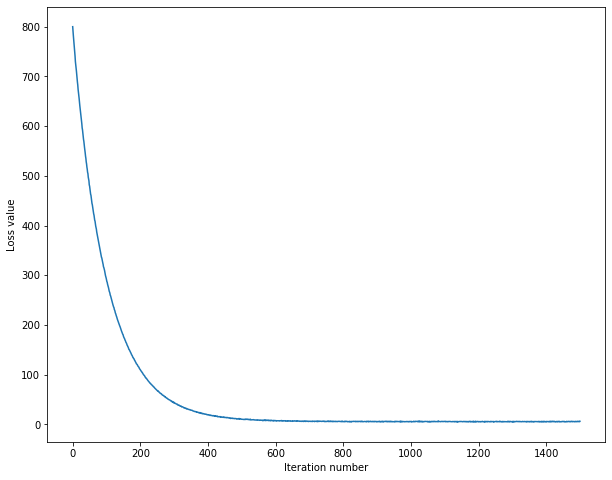

training accuracy: 0.368898
validation accuracy: 0.374000


In [17]:
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

# A useful debugging strategy is to plot the loss as a function of
# iteration number:
# you should see a nicely decreasing loss curve
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

<font size='4' color='red'>**Task 4.1: tune the hyperparameters for the SVM classifier to get a classification accuracy over 0.4 on the validation set (5 points)**

In [18]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

grid = [ (lr,reg) for lr in learning_rates for reg in regularization_strengths ]

for lr, reg in grid:
    svm = LinearSVM()
    train_loss = svm.train(X_train, y_train, learning_rate = lr, reg = reg, num_iters=1500, verbose=False)
    ytrain_pred = svm.predict(X_train)
    train_acc = np.mean(ytrain_pred == y_train)
    
    yval_pred = svm.predict(X_val)
    val_acc = np.mean(yval_pred == y_val)
    
    results[(lr,reg)] = (train_acc, val_acc)
    if best_val < val_acc:
        best_val = val_acc
        best_svm = svm

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in double_scalars
D:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in multiply
D:\Anaconda3\lib\site-packages\numpy\core\_methods.py:47: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: overflow encountered in multiply


lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.373816 val accuracy: 0.376000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.359714 val accuracy: 0.366000
lr 5.000000e-05 reg 2.500000e+04 train accuracy: 0.052898 val accuracy: 0.050000
lr 5.000000e-05 reg 5.000000e+04 train accuracy: 0.100265 val accuracy: 0.087000
best validation accuracy achieved during cross-validation: 0.376000


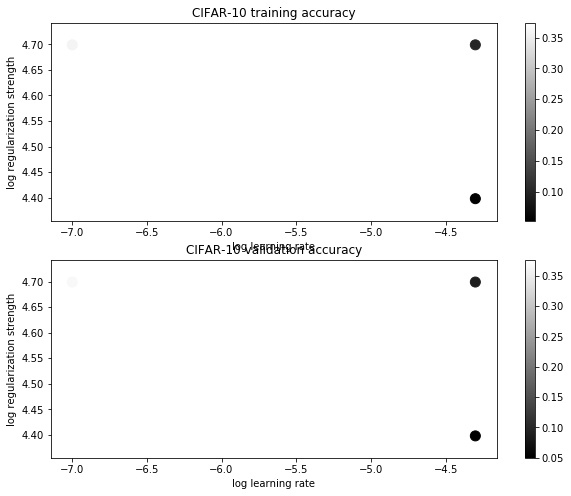

In [19]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [20]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.371000


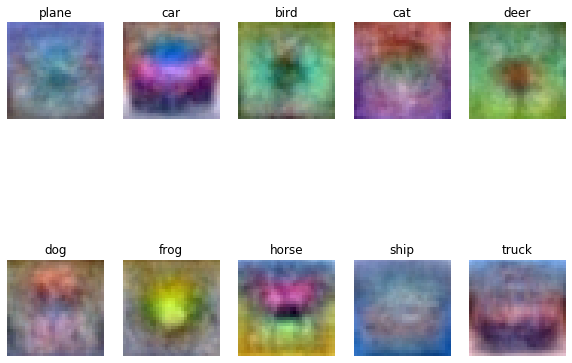

In [21]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

<font size='4' color='red'>**Inline question 4.1:**
<font size='4' color='red'>**Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do. (2 points)**

**Fill in your answer below**
    
[FILL IN THIS] SVM weights look like a combination of images for each class. Because the precision attained was low, the photos are blurry. For example, the weights of the class ship looks like it has blue background because many ship images might have contained water in background. This happened because in the dataset we have a variety of images of ships, each in different pose, orientation, landscape, and image features. Here, we use the inner product to compare the test image to the templates and the weights for each class are templates learnt from the data. 

### Softmax classifier training

<font size='4' color='red'>**Task 4.2: Tune the hyperparameters for the Softmax classifier to get a classification accuracy of over 0.35 on the validation set. (5 points)**

In [22]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

for reg in regularization_strengths:
    for lr in learning_rates:
        softmax = Softmax()
        softmax.train(X_train, y_train, lr, reg, num_iters=1500)
        
        ytrain_pred = softmax.predict(X_train)
        train_acc = np.mean(y_train == ytrain_pred)
        
        yval_pred = softmax.predict(X_val)
        val_acc = np.mean(y_val == yval_pred)
        
        if val_acc > best_val:
            best_val = val_acc
            best_softmax = softmax           
        results[(lr,reg)] = train_acc, val_acc

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.350898 val accuracy: 0.366000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.330531 val accuracy: 0.341000
lr 5.000000e-07 reg 2.500000e+04 train accuracy: 0.351959 val accuracy: 0.365000
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.336918 val accuracy: 0.340000
best validation accuracy achieved during cross-validation: 0.366000


In [23]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.364000


<font size='4' color='red'>**Inline Question 4.2** - *True or False*

<font size='4' color='red'>**It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss. (2 points)**

*Your answer*: True

*Your explanation*: Adding a new datapoint leaves the SVM loss unchanged, but changes Softmax classifier loss as SVM loss is a local objective, i.e. it concerns with only the margin being satisfied and is unaffected by the addition of a datapoint. In calculating the loss, the Softmax classifier takes into account all of the individual scores.
    
For example, let's add a new datapoint that leads to scores [10,6,8], the margin for SVM is 2 and the correct class is 1. Now, max(0, 6 + 2 - 10) + max(0, 8 + 2 - 10) = 0 , as the margin is satisfied, SVM loss of this datapoint will be 0. Thus, SVM loss remains unchanged. In the case of the Softmax classifier, however, the loss will grow i.e. -ln(softmax(10)) = -ln(0.84) = 0.17.

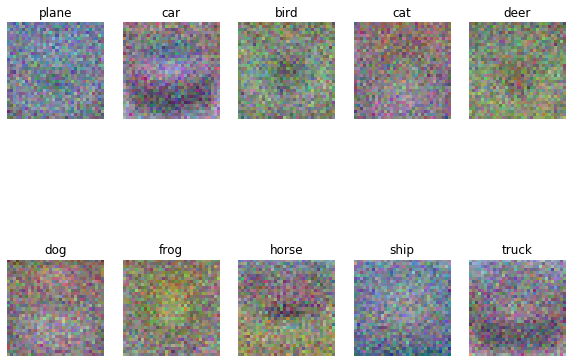

In [24]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])